In [296]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.cross_decomposition import CCA
import pandas as pd

In [297]:
fs = 250       #Frequência de amostragem
#Vai do instante 0.64 até 3.64
start_time = 0.64  
window_duration = 3.0  
start_sample = int(start_time * fs)  
end_sample = start_sample + int(window_duration * fs) 
bloco = 2                   
alvo = 20                   
eletrodos_alvo = ['PZ', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2']

In [298]:
channels_df = pd.read_csv('64-channels.loc', delim_whitespace=True, header=None, 
                          names=["idx", "x", "y", "label"])

In [299]:
idx_eletrodos = []
for eletrodo in eletrodos_alvo:
    idx = int(channels_df[channels_df['label'] == eletrodo]['idx'].iloc[0])
    idx_eletrodos.append(idx)

In [300]:
mat = scipy.io.loadmat('S3.mat')
data = mat['data']

In [301]:
#Aplica o filtro de 3Hz e o janelamento

signals = np.zeros((len(idx_eletrodos), end_sample - start_sample))
for i, idx in enumerate(idx_eletrodos):
    signal = data[idx, start_sample:end_sample, alvo, bloco]  
    b, a = butter(4, 3 / (fs / 2), btype='highpass') 
    signals[i] = filtfilt(b, a, signal)

In [302]:
eeg_window = np.mean(signals, axis=0)

In [303]:
#Extrai a freq de estímulo

freq_phase = scipy.io.loadmat('Freq_Phase.mat')
freqs_estimulo = freq_phase['freqs'] 
f_alvo = freqs_estimulo[0, alvo] 

In [304]:
rho_values = np.zeros(40) 

#Controi Y e aplica cca
for m in range(40):
    f = freqs_estimulo[0, m]
    
   
    t = np.linspace(0, (end_sample - start_sample)/fs, end_sample - start_sample, endpoint=False)
    Yf_sin = np.sin(2 * np.pi * f * t)
    Yf_cos = np.cos(2 * np.pi * f * t)
    Y2f_sin = np.sin(2 * np.pi * 2 * f * t)
    Y2f_cos = np.cos(2 * np.pi * 2 * f * t)
    
    
    Y_ref = np.vstack([Yf_sin, Yf_cos, Y2f_sin, Y2f_cos]).T
    
    cca = CCA(n_components=1)
    X_cca, Y_cca = cca.fit_transform(eeg_window.reshape(-1, 1), Y_ref)
    rho = np.corrcoef(X_cca.T, Y_cca.T)[0, 1]
    rho_values[m] = rho

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


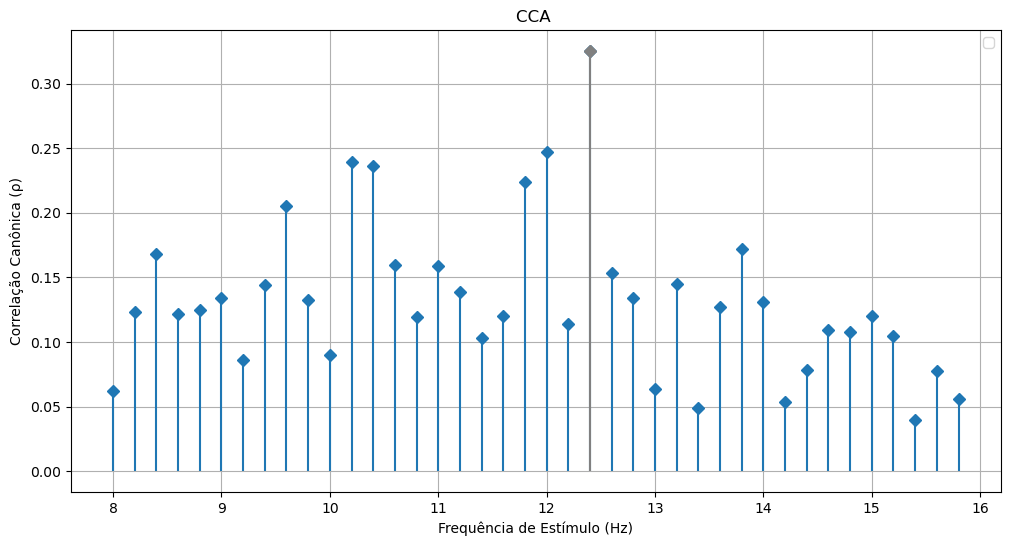

In [305]:
idx_max = np.argmax(rho_values)
max_rho = rho_values[idx_max]
f_max = freqs_estimulo[0, idx_max]


plt.figure(figsize=(12, 6))
plt.stem(freqs_estimulo[0], rho_values, basefmt=" ", use_line_collection=True, markerfmt='D')
if f_max != f_alvo:
    markerline, stemlines, baseline = plt.stem(f_max, max_rho, basefmt=" ", use_line_collection=True, linefmt='red', markerfmt='D')
    plt.stem(f_alvo, rho_values[alvo], basefmt=" ", use_line_collection=True, linefmt='purple', markerfmt='D')
    markerline.set_markerfacecolor('red')
    markerline.set_markeredgecolor('red')
else:
    markerline, stemlines, baseline = plt.stem(f_max, max_rho, basefmt=" ", use_line_collection=True, linefmt='gray', markerfmt='D')
    markerline.set_markerfacecolor('gray')
    markerline.set_markeredgecolor('gray')
plt.xlabel('Frequência de Estímulo (Hz)')
plt.ylabel('Correlação Canônica (ρ)')
plt.title('CCA ')
plt.grid(True)
plt.legend()
plt.show()
